# Report

---

### 1. Learning Algorithm

This solution uses a deep Q-network with experience replay and fixed Q-targets.

**Deep Q-Network** - trains a neural network to estimate the Q-function. Normally the Q-function takes the state and action as input and returns a value (the expected total discounted returns by taking that action in that state and following the current policy for all future actions), but in this implementation the neural network takes the state as the input and returns a value for each possible action.

**Neural Network Model** - the underlying model is a neural network that consists of an input layer (with 37 inputs), two fully-connected hidden layers (each with 64 nodes), and an output layer (with 4 outputs). The activation function is the rectified linear unit (ReLU), which returns the input value if the input is positive and 0 otherwise.

**Experience Replay** - Rather than update the model following each action taken, each transition (consisting of a state, action, reward, and new state) is saved into a fixed-length queue (in this case, 100,000). Learning occurs after every 4 time steps, at which point a minibatch of 64 transitions is sampled from the replay buffer and the model is updated using that sample. This is done to break harmful correlations, learn more from individual tuples multiple times, recall rare occurrences, and in general make better use of our experience.

**Fixed Q-target** - We use a gradient descent update process which seeks to minimize TD (temporal difference) error - this compares the the sum of observed return in one time step (having taking an action in a given state) and expected discounted future returns under that policy to the function value for that action and state pair. However, instead of using the same function to calculate expected discounted future returns at each step, we use a second 'fixed' model that updates less frequently than our primary (local) model. This model has the same structure as our primary model, but is only updated every 4 time steps using the following equation (here tau is equal to 0.001): 

θ_target = τ*θ_local + (1 - τ)*θ_target 

Fixed Q-target prevents a harmful form of correlation caused by shifting the parameters of the model based on a constantly-moving target.

**Additional Hyperparameters** - The following hyperparameter values were used in training the Q-network (in addition to those mentioned above):

learning rate = 0.0005 - used in the gradient descent update process for local model weights occurring every 4 times steps (with the delta equaling learning rate times TD error times the gradient of the model with respect to the weights).

Gamma = 0.99 - Discount factor for future returns (discounting at each time step)

epsilon = 1 to 0.01, decaying by epsilon = 0.995 * epsilon each episode - used in choosing the action under the epsilon greedy policy. With probability epsilon, choose a random action at time step t, otherwise choose the action that maximizes the Q-function in that state.





In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


Load the unity environment

In [2]:
from unityagents import UnityEnvironment
import numpy as np

# the following will only work with linux OS
env = UnityEnvironment(file_name="/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agent while it is training**, and you should set `train_mode=True` to restart the environment.

In [5]:
env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 0.0


When finished, you can close the environment.

In [6]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

# Solution



Import additional libraries

In [7]:
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from dqn_agent import Agent
%matplotlib inline

plt.ion()

Initialize agent

In [9]:
agent = Agent(state_size=state_size, 
              action_size=action_size, seed=0)


# 2. Plot of Rewards

The environment was solved after 582 episodes with a mean return of 13.01 over 100 consecutive episodes (episodes 483 to 582). The model weights can be found in `checkpoint.pth`

Episode 100	Average Score: 1.75
Episode 200	Average Score: 6.06
Episode 300	Average Score: 9.48
Episode 400	Average Score: 10.58
Episode 500	Average Score: 10.69
Episode 582	Average Score: 13.01
Environment solved after 582 episodes!	Average Score: 13.01


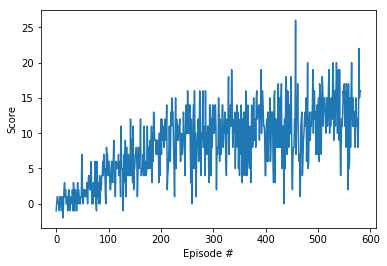

In [12]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]            # get the current state
        score = 0                                          # initialize the score
        for t in range(max_t):
            action = agent.act(state, eps)                 # determine epsilon-greedy action 
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>13:
            print('\nEnvironment solved after {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
            break
    return scores

scores = dqn()

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

# 3. Ideas for future work

**Double DQN** - The learning algorithm used tends to overstimate action values(we're always picking the maximum among a set of noisy numbers), especially in the early iterations. One way to address this is to use one set of parameters to choose an action, and another to evaluate its value. In this case, we already have a second DQN we use for the fixed Q-target that we can also use for this purpose.

**Prioritized Experience Replay** - Rather than sample from the experience replay buffer with uniform probability, we can increse the chance of selecting important transitions that may not occur frequently. We can consider transitions with larger TD error as more important (i.e. we have more to learn from them) and use that value to weight the transitions in the buffer. Thus, the probability of being selected is a transition's TD error divided by the sum of all transitions' TD errors in the buffer.